## Analysis of healthy individuals at risk of developing a Mild Cognitive Impairment in 3-5 years

** Data request approved by the ADNI executives to use database https://adni.loni.usc.edu/ **

*The aim of the study was to determine which individuals are at risk of developing a Mild Cognitive Impairment (MCI) within 3-5 years using only demographic variables and neuropsychiatric questionnaires. In other words, data that is accessible and doesn't require brain scans or invasive procedures.* 

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2, SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import NearestNeighbors


### The Dataset

*The data was downloaded as a .csv file from ADNI database. It contained over 100 variables of demographic, psychological, genetic, neuroimaging and biospecimen information from 1450 participants. The dataset was removed of all variables that were not generally accessible to people e.g. neuroimaging. Participants were chosen who showed no cognitive impairment during their initial screening visit. This was determined using the Clinical Dementia Rating (CDR) scale; a semi structured interview to assess skills such as memory and judgement. A follow up CDR score was collected between 3 to 5 years to determine whether they had developed a Mild Cognitive Impairment (MCI).The data was processed using Microsoft Excel, converting strings to integers, to use in Python.*


In [2]:
# Load dataset
data = pd.read_csv("Datasets/COMPLETE DATASET.csv")

# Make all data floating points
data = data.astype(float)


### Description of the variables
###### (Note these have been organised by target variable, categorical variables the continous variables.)

| Variable | Metric | Table Key: Value | Brief Description|
| --- | --- | --- | --- |
| Impaired | T or F | Healthy: 0, Impaired: 1 | Mild Cognitive Impairment in 3-5 years
| Apoe4 | # no. | None: 0, One: 1, Two: 2 | APOE4 gene carrier
| Age | Years | categ | Age of person
| Gender | categ | Male: 1, Female: 2 | Gender assigned at birth
| Eth | categ | Hispanic: 1, Non-Hispanic: 2 | Hispanic specific ethnicity
| Race | categ | Asian: 2, Black or African: 4, White: 5, Multiple reported: 6 | Racial Background |
| Hand | categ | Right: 1, Left: 2 | Dominant hand type 
| Marry | categ | Married: 1, Widowed: 2, Divorced: 3, Never Married: 4, Unknown: 5 | Marital status
| Home | categ | House: 1, Condo: 2, Apartment: 3, Mobile home: 4, Retirement Community: 5, other: 8 | Type of Residency
| Retired | categ | Retired: 1, Not retired: 2 | Retirement status 
| Occupation | categ | Level 1 (e.g. cleaner): 1, Level 2 (e.g. butcher): 2, Level 3 (e.g. shop manager): 3, Level 4 (e.g. secondary teacher): 4 | Occupational Complexity
| Education | Years | cont | Years of Formal Education
| Depression | Test score | cont | Geriatric Depression Scale - A measure of depression (total /15; > 5 indicates depression)
| NIQ | Test score | cont | Neuropsychiatric Inventory Questionnaire - A measure of behaviour changes consistent with Alzheimers e.g. delusions, hallucinations, agitation/aggression, dysphoria, anxiety etc. (total /36)
| FAQ | Test score | cont | Functional Activities Questionnaire - The FAQ is a test that can be used to assess a patient’s dependency on another to carry out normal daily tasks, total /30, > 9 indicates impairment/dependency
| Weight | kg | cont | Weight
| Height | cm | cont | Height
| Temp | deg c | cont | Temperature at appointment
| Systolic | mmHg | cont | Systolic Blood Pressure
| Dystolic | mmHg | cont | Diastolic Blood Pressure
| Pulse | bpm | cont | Resting pulse rate 
| Resp | rpm | cont | Respirations per minute


### Data preparation

We can start with an overview of the data and by comparing participants who became impaired with those who did not. The main differences appear to be in neuropsychological questionnaires, weight and blood pressure.

In [3]:
# Create new mask variable for patients who developed MCI
mask = data['Impaired'] == 1.000

# Filter data using mask variable
Impaired = data[mask]

# Create mask for patients who did not develop MCI
mask = data['Impaired'] == 0 

# Filter data using mask 
no_Impaired = data[mask]

# New empty DataFrame to display differences
summary = pd.DataFrame() 
summary['Impaired'] = Impaired.mean()
summary['No_Impaired'] = no_Impaired.mean()

summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Impaired    260 non-null    float64
 1   Apoe4       260 non-null    float64
 2   Gender      260 non-null    float64
 3   Eth         260 non-null    float64
 4   Race        260 non-null    float64
 5   Hand        260 non-null    float64
 6   Marry       260 non-null    float64
 7   Home        260 non-null    float64
 8   Retired     260 non-null    float64
 9   Occupation  260 non-null    float64
 10  Education   260 non-null    float64
 11  Depression  260 non-null    float64
 12  NPI         260 non-null    float64
 13  FAQ         260 non-null    float64
 14  Age         260 non-null    float64
 15  Weight      260 non-null    float64
 16  Height      260 non-null    float64
 17  Temp        260 non-null    float64
 18  Systolic    260 non-null    float64
 19  Diastolic   260 non-null    f

,Impaired,No_Impaired
Impaired,1.000000,0.000000
Apoe4,0.346667,0.297297
Gender,1.440000,1.600000
Eth,1.986667,1.962162
Race,4.880000,4.929730
Hand,1.093333,1.086486
Marry,1.360000,1.524324
Home,1.546667,1.454054
Retired,0.813333,0.794595
Occupation,2.933333,2.881081


### Data Preprocessing 

We start by defining our target and predictor variables. 

Next we need to separate our categorical variables into unique columns by one hot encoding. 

The values then need to be displayed as floating point values, where 1.0 indicates presence of variable and 0.0 indicates absense. 


In [4]:
# Create Target Variable y (whether participant develops impairment or not)
y = data['Impaired'].astype(int)

# Create dataset of predictor variables X
X = data.drop(columns=["Impaired"])

# Create continuous and categorical variables
X_categ = X.loc[:,'Apoe4': 'Occupation'].astype(int)
X_cont = X.loc[:, 'Education': 'Resp']

# Convert categorical variables to string to use get_dummies function
X_categ = X_categ.astype(str)

# Convert categorical variables into Dummy Variables.
X_categ_dum = pd.get_dummies(X_categ, columns= None, dtype= int)

# Combine categorical and continuous data into one dataframe
X_processed = pd.concat([X_categ_dum, X_cont], axis=1)

X_processed.head()

,Apoe4_0,Apoe4_1,Apoe4_2,Gender_1,Gender_2,Eth_1,Eth_2,Race_2,Race_4,Race_5,...,NPI,FAQ,Age,Weight,Height,Temp,Systolic,Diastolic,Pulse,Resp
0,1,0,0,1,0,0,1,0,0,1,...,0.0,0.0,86.0,48.0,144.0,97.0,140.0,88.0,60.0,22.0
1,0,1,0,1,0,0,1,0,0,1,...,0.0,0.0,73.0,49.0,180.0,97.0,130.0,70.0,60.0,16.0
2,1,0,0,1,0,0,1,0,0,1,...,0.0,0.0,74.0,50.0,170.0,97.0,112.0,70.0,56.0,12.0
3,1,0,0,1,0,0,1,0,0,1,...,0.0,0.0,79.0,55.0,171.0,98.0,152.0,84.0,66.0,21.0
4,1,0,0,0,1,1,0,0,0,1,...,0.0,0.0,78.0,56.0,145.0,97.0,148.0,72.0,64.0,16.0


## Training_Test split

Then, we can split the dataframe into training and test data. Training data is used to fit the Machine Learning model. On the contrary, test data is used to evaluate the performance or accuracy of the model. It's a sample of data used to make an unbiased evaluation of the final model fit on the training data.

When it comes to splitting data for training and testing in machine learning, a commonly recommended ratio is 80/20 or 70/30. The choice of the split ratio depends on several factors such as the size of the dataset, the complexity of the model, and the specific problem domain. For a smaller dataset 70/30 is more appropriate.

In [5]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.3)

## Standardizing the data 

Many Machine Learning algorithms, as a rule of thumb, benefit from the data being Standardized. For example, Heights might range from 0.5 to 1.5 meters, while weights could range from 5 to 50 kilograms. Without standardizing, the weight might dominate the analysis because its values are larger. 

Standardizing variables follows the equation {z = (x - u) / s} where x is a datapoint, u is the mean of the sample and s is the standard deviation of the sample. 

In [6]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Apply the scaler to the training and test sets
    train_std=sc.fit_transform(X_train)
    test_std=sc.fit_transform(X_test)
    
    return train_std, test_std

X_train_std, X_test_std = standardise_data(X_train, X_test)

In [7]:
# View standardized data in a new dataframe
X_variables = pd.DataFrame(X_train_std, columns= X_processed.columns)

# Get data info 
X_variables.info()

X_variables.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 42 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Apoe4_0       182 non-null    float64
 1   Apoe4_1       182 non-null    float64
 2   Apoe4_2       182 non-null    float64
 3   Gender_1      182 non-null    float64
 4   Gender_2      182 non-null    float64
 5   Eth_1         182 non-null    float64
 6   Eth_2         182 non-null    float64
 7   Race_2        182 non-null    float64
 8   Race_4        182 non-null    float64
 9   Race_5        182 non-null    float64
 10  Race_6        182 non-null    float64
 11  Hand_1        182 non-null    float64
 12  Hand_2        182 non-null    float64
 13  Marry_1       182 non-null    float64
 14  Marry_2       182 non-null    float64
 15  Marry_3       182 non-null    float64
 16  Marry_4       182 non-null    float64
 17  Marry_5       182 non-null    float64
 18  Home_1        182 non-null    

,Apoe4_0,Apoe4_1,Apoe4_2,Gender_1,Gender_2,Eth_1,Eth_2,Race_2,Race_4,Race_5,...,NPI,FAQ,Age,Weight,Height,Temp,Systolic,Diastolic,Pulse,Resp
0,-1.694798,1.825742,-0.168073,-0.87578,0.87578,-0.184637,0.184637,-0.105409,-0.214423,0.253629,...,-0.423999,-0.281341,1.312247,-1.385393,-2.242347,0.505366,-0.696564,-0.600795,0.143759,1.334641
1,0.590041,-0.547723,-0.168073,1.14184,-1.14184,-0.184637,0.184637,-0.105409,-0.214423,0.253629,...,-0.423999,-0.281341,1.989456,-1.224074,-0.761552,0.505366,-0.359397,0.867677,-0.039849,-0.178784
2,-1.694798,1.825742,-0.168073,1.14184,-1.14184,-0.184637,0.184637,-0.105409,-0.214423,0.253629,...,0.317999,-0.281341,-0.267907,-0.820777,-0.662832,0.505366,-1.640629,-1.391511,0.051955,0.577929
3,0.590041,-0.547723,-0.168073,-0.87578,0.87578,-0.184637,0.184637,-0.105409,-0.214423,0.253629,...,1.059998,-0.281341,-0.493643,-0.820777,-0.958991,0.505366,1.528735,1.093596,-0.131653,-0.178784
4,0.590041,-0.547723,-0.168073,-0.87578,0.87578,-0.184637,0.184637,-0.105409,-0.214423,0.253629,...,-0.423999,-0.281341,-0.719379,0.227797,0.916683,0.505366,-0.494264,0.415840,0.143759,-0.178784


We can visualize the distribution of these variables after standardizing them by looking at histograms. I have created two graphs; one that shows the variables that continue to looked skewed, namely the neuropsychological variables, and the range of other normal looking variables. 

<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

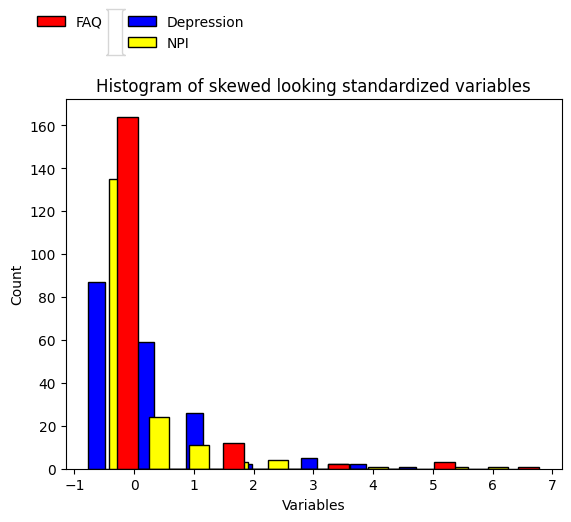

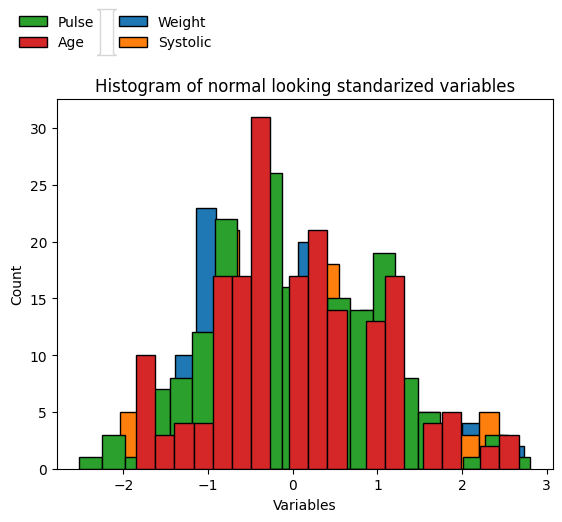

In [8]:
# Draw two figures and prepare graphs
figure, graph = plt.subplots()
figure2, graph2 = plt.subplots()

# Label axis and title of first graph
graph.set_xlabel("Variables")
graph.set_ylabel("Count")
graph.set_title("Histogram of skewed looking standardized variables")

# Label axis and title of second graph
graph2.set_xlabel("Variables")
graph2.set_ylabel("Count")
graph2.set_title("Histogram of normal looking standarized variables")

# Plot histogram of variables that are skewed
graph.hist(X_variables['Depression'], edgecolor='black', bins=20, color= "blue", label = 'Depression') 
graph.hist(X_variables['NPI'], edgecolor='black', bins=20, color = "yellow", label = 'NPI')
graph.hist(X_variables['FAQ'], edgecolor='black', bins=20, color = "red", label = 'FAQ')
graph.legend(bbox_to_anchor=(0.1,1.1), ncol=2, mode='expand', loc='lower left')


# Plot histograms of variables that are normally distributed
graph2.hist(X_variables['Weight'], edgecolor='black', bins=20, label = 'Weight')
#graph2.hist(X_variables['Height'], edgecolor='black', bins=20)
graph2.hist(X_variables['Systolic'], edgecolor='black', bins=20, label = 'Systolic')
#graph2.hist(X_variables['Diastolic'], edgecolor='black', bins=20)
#graph2.hist(X_variables['Resp'], edgecolor='black', bins=20)
graph2.hist(X_variables['Pulse'], edgecolor='black', bins=20, label = 'Pulse')
graph2.hist(X_variables['Age'], edgecolor='black', bins=20, label = 'Age')
graph2.legend(bbox_to_anchor=(0.1,1.1), ncol=2, mode='expand', loc='lower left')

# Show graphs
figure.show
figure2.show



## Training the model

Our baseline will be a Logistic Regression model, which is a well-known supervised Machine Learning algorithm for classification problems.

In [9]:
# Create Logistic Regression model 
model = LogisticRegression()

# Tune model on training data
model.fit(X_train_std,y_train)

LogisticRegression()

In [10]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)


In [11]:
# Accuracy of the model
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:.1%}')
print (f'Accuracy of predicting test data = {accuracy_test:.1%}')

Accuracy of predicting training data = 77.5%
Accuracy of predicting test data = 71.8%


The initial accuracy recorded of this model is quite low on both the training and testing datasets. In addition, the accuracy is significantly lower on the testing data, than the training data. This could indicate model overfitting. Overfitting refers to the model capturing higher amount of variance (or noise) from the training data, rather than true relationships, therefore it performs poorer on the unseen training data. 

There are a few things we can do to improve our baseline logistic regression model, such as Feature selection, which we can perform by analysing the model coefficients. 

## Examining the model coefficients (weights)

Not all features are equally important. And some may be of little or no use at all, unnecessarily increasing the complexity of the model. 

Here we will look at the importance of features in terms of how they are related to the development of Cognitive Impairment. These are known as the model *coefficients* (if you come from a traditional statistics background), or model *weights* (if you come from a machine learning background). 

Because we have standardised our input data the magnitude of the weights may be compared as an indicator of their influence in the model. Weights with higher negative numbers mean that that feature correlates with reduced chance of Impairment. Weights with higher positive numbers mean that that feature correlates with increased chance of Impairment. Those weights with values closer to zero (either positive or negative) have less influence in the model.


In [12]:
# Get model coefficients
co_eff = model.coef_[0]

# Store coefficients in a new dataframe 
co_eff_df = pd.DataFrame()

# Get feature names from 
co_eff_df['feature'] = list(X_variables)
co_eff_df['co_eff'] = co_eff
co_eff_df['abs_co_eff'] = np.abs(co_eff)
co_eff_df.sort_values(by='abs_co_eff', ascending=False, inplace=True)

co_eff_df

,feature,co_eff,abs_co_eff
34,Age,0.758868,0.758868
23,Home_8,-0.460644,0.460644
2,Apoe4_2,0.284013,0.284013
32,NPI,0.275597,0.275597
3,Gender_1,0.261538,0.261538
4,Gender_2,-0.261538,0.261538
38,Systolic,0.195272,0.195272
10,Race_6,-0.190514,0.190514
15,Marry_3,-0.185502,0.185502
14,Marry_2,0.177693,0.177693


## Feature Selection

We can run the logistic regression model several times, each time adding another feature, to assess the optimal number of features for model accuracy. 

We have examined the correlation coefficient between each feature and the target variables. This is an example of univariate statistical modelling, as we examined each feature independently.

Two key advantages of this method are its simplicity and speed, however it may miss features which have little effect alone, but which are influential when combined. Also, it does not account for multicollinearity, where independent features are highly correlated and therefore have greater influence on the model, where one should be removed. 

In [13]:
# Create list of ordered features
ordered_features = list(co_eff_df['feature'])

# Create list to store accuracies
train_acc_by_feature_number = []
test_acc_by_feature_number = []

# Loop through feature list
number_of_features = len(ordered_features)

for i in range(number_of_features):
    # print ("{0} features of {1}".format(i, number_of_features))
    features_to_use = ordered_features[0:i+1]

    # Get features from original dataset 
    X_selected = X_processed[features_to_use]
 
    # Get training and testing splits
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=0)
    
    # Standardize the training and test data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
          
    # Set up and fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std,y_train)

    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    
    # Calculate accuracy of training and testing sets
    accuracy_train = np.mean(y_pred_train == y_train)
    accuracy_test = np.mean(y_pred_test == y_test)
    
    train_acc_by_feature_number.append(accuracy_train)
    test_acc_by_feature_number.append(accuracy_test)
  

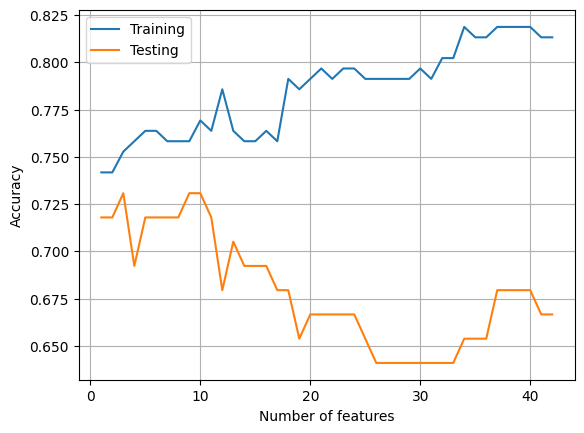

In [14]:
# Create line graph to visualise accuracy by feature 
chart_x = list(range(1, number_of_features + 1))

plt.plot(chart_x, 
        train_acc_by_feature_number,
        label = 'Training')

plt.plot(chart_x, 
         test_acc_by_feature_number, 
         label = 'Testing')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

We can see from the graph above that there is an optimal number of features to select
to improve model accuracy for both testing and training data.

In [15]:
# Run the model again with highest 8 features
X_selected_2 = X_processed[['Age', 'FAQ', 'Weight', 'Gender_2','Apoe4_0', 'Resp', 'Depression', 'Systolic']]
                           
# Get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_2, y, test_size=0.3, random_state=0)

# Standardize the training and test data
X_train_std, X_test_std = standardise_data(X_train, X_test)
  
# Set up and fit model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_std,y_train)

# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

# Calculate accuracy of training and testing sets
train_acc = np.mean(y_pred_train == y_train)
test_acc = np.mean(y_pred_test == y_test)

# Calculate precision and recall of testing data
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score (y_test, y_pred_test)

print('Logistic Regression\n')
print(f'Training accuracy: {train_acc:.1%}')
print(f'Testing data: {test_acc:.1%}')
print(f'Test precision: {test_precision:.1%}')
print(f'Test recall: {test_recall:.1%}')


Logistic Regression

Training accuracy: 77.5%
Testing data: 69.2%
Test precision: 58.3%
Test recall: 26.9%


## Model Performance

Below are some key performance metrics:

--Accuracy is the ratio of correctly predicted instances to the total instances. 

--Precision is the ratio of correctly predicted positive instances to the total predicted positive instances. 

--Recall is the ratio of correctly predicted positive instances to all actual positive instances.

Depending on our goal, we should pay closer attention to a specific metric. For example, high precision is good when false positives are costly or undesirable (e.g. Spam detection - where marking a legitimate email as spam is problematic). High Recall is better when false negatives are costly or undesirable (e.g. cancer detection - where missing a cancer case is much worse than a false alarm).

In our example, the cost of false negatives is higher and therefore we need to pay closer attention to the recall rate. This figure is low for our Logistic Regression model and therefore problematic.

## Confusion Matrix

A confusion matrix is a performance evaluation tool used in classification tasks to visualize the accuracy of a model. It is a table that summarizes the number of correct and incorrect predictions across different classes by comparing the actual labels with the predicted labels.

The matrix consists of four main elements for binary classification:

1. **True Positives (TP)**: Correctly predicted positive cases.
2. **True Negatives (TN)**: Correctly predicted negative cases.
3. **False Positives (FP)**: Incorrectly predicted positive cases (also known as Type I error).
4. **False Negatives (FN)**: Incorrectly predicted negative cases (also known as Type II error).

For multi-class classification, the confusion matrix expands to reflect the results for each class. It helps in understanding which classes are being confused by the model, aiding in error analysis.

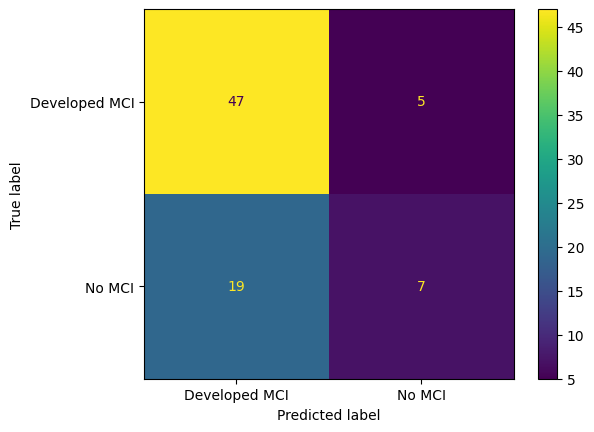

In [16]:
confusion_matrix_dt = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        y_true = y_test,
        y_pred=y_pred_test,
    ),
    display_labels=['Developed MCI', 'No MCI']
    )

confusion_matrix_dt.plot()

plt.show()

## Receiver Operator Characteristic (ROC) Curves 

These are useful in assessing the potential performance of a Machine Learning algorithm. They plot the True Positive Rate (proportion of cases correctly identified as positive out of all positive cases; sensitivity) against the False Positive Rate (proportion of cases incorrectly identified as positive out of all negative cases; specificity).

For example, a False Positive Rate of 20% would mean that 20% of cases that are negative we would incorrectly classify as being positive.

We plot these rates for varying prediction thresholds. The prediction
threshold is the value above which we classify something as positive (and
below which, something is classified as negative). By default, this is usually
0.5, but that may not always be the best threshold, particularly for imbalanced datasets.

A ROC curve allows us to assess if we could get better performance with a
different threshold, or if the model just isn’t going to work as it stands.


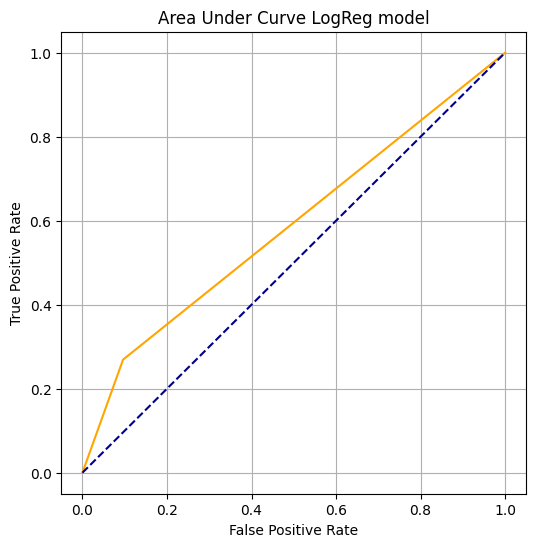

In [17]:
# Get fpr, tpr and thresholds fron testing data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the curve 
roc_auc = auc(fpr, tpr)

# Create figure
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
ax1.plot(fpr, tpr, color= 'orange')
ax1.plot([0,1],[0,1], color='darkblue', linestyle='--')

ax1.set_title('Area Under Curve LogReg model')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
plt.grid(True)
plt.show()

## Improving our model

Now we will attempt to improve on our Logisitic Regression baseline model using a variety of different techniques, including tuning a new model and balancing our class data.

### XGBooster Algorithm

XGBoost, which stands for “eXtreme Gradient Boosting,” is an advanced implementation of the gradient boosting algorithm. Gradient boosting is a machine learning technique where the main idea is to combine many simple models, also known as “weak learners,” to create an ensemble model that is better at prediction.

In [18]:
# Import xgboost model
from xgboost.sklearn import XGBClassifier

Here I have created a function that takes data array parameters (X, y) and a model to use. The function will perform many tasks, such as training and test split, before showing metrics for model performance. This will make it easier to tune the XG model. 

In [19]:
# Function to prepare data and then run chosen model
def train_and_run_dt(X, y, model):

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

    # Fit 
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    accuracy_train = np.mean(y_pred_train == y_train)
    accuracy_test = np.mean(y_pred_test == y_test)

    # Performance of model
    print (f'Accuracy of predicting training data = {accuracy_train:.3f}')
    print (f'Accuracy of predicting test data = {accuracy_test:.3f}')

    print (f'Precision on test data = {precision_score(y_test, y_pred_test):.3f}')
    print (f'Recall on test data = {recall_score(y_test, y_pred_test):.3f}')
    print (f'Specificity on test data = {precision_score(y_test, y_pred_test, pos_label=0):.3f}')
    
    confusion_matrix_dt = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        y_true = y_test, 
        y_pred=y_pred_test
    ),
    display_labels=['No MCI', 'Developed MCI']
    )

    confusion_matrix_dt.plot()

    plt.show()

    # Get fpr, tpr and thresholds fron testing data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

    # Calculate the area under the curve 
    roc_auc = auc(fpr, tpr)

    # Create figure
    fig = plt.figure(figsize=(6,6))

    # Plot ROC
    ax1 = fig.add_subplot()
    ax1.plot(fpr, tpr, color= 'orange')
    ax1.plot([0,1],[0,1], color='darkblue', linestyle='--')

    ax1.set_title('Area Under Curve XGBoost model')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

    return(model)

c:\Users\thoma\anaconda3\envs\ML\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of predicting training data = 1.000
Accuracy of predicting test data = 0.731
Precision on test data = 0.385
Recall on test data = 0.278
Specificity on test data = 0.800


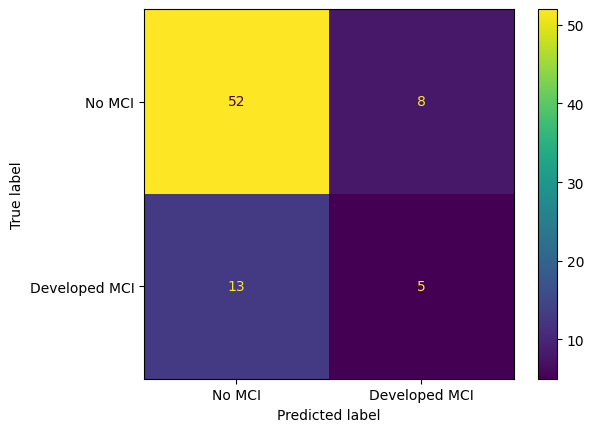

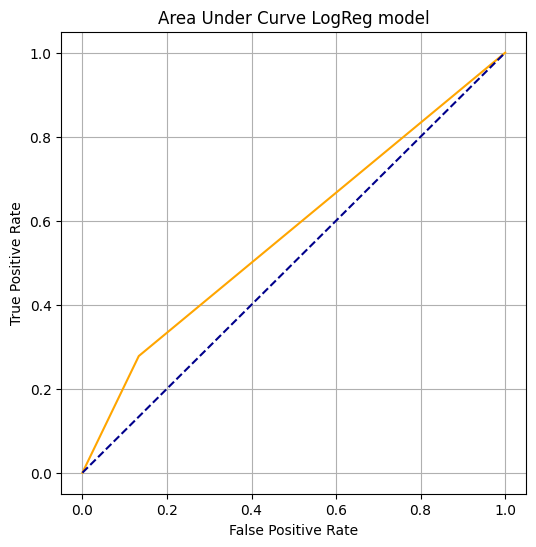

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
# Create a baseline XGBClassifier model (before tuning)
model = XGBClassifier(randomstate=42)
# Metrics
train_and_run_dt(X_processed, y, model)

 We can see the baseline model is overfitted (the training data set accuracy is much larger than the testing set). Additionally the precision and recall values are low and could improve. Here we try to tune parameters of the model. 

c:\Users\thoma\anaconda3\envs\ML\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of predicting training data = 0.797
Accuracy of predicting test data = 0.769
Precision on test data = 0.500
Recall on test data = 0.222
Specificity on test data = 0.800


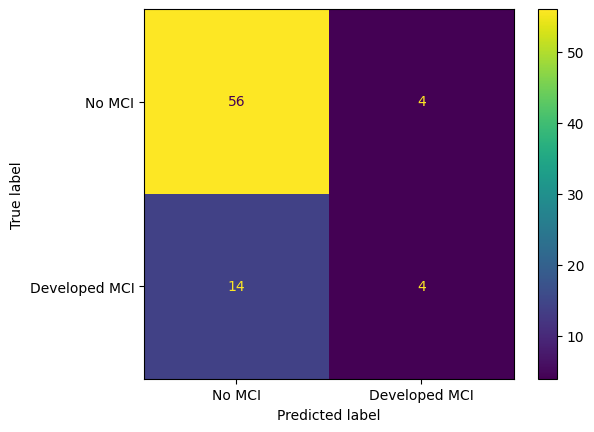

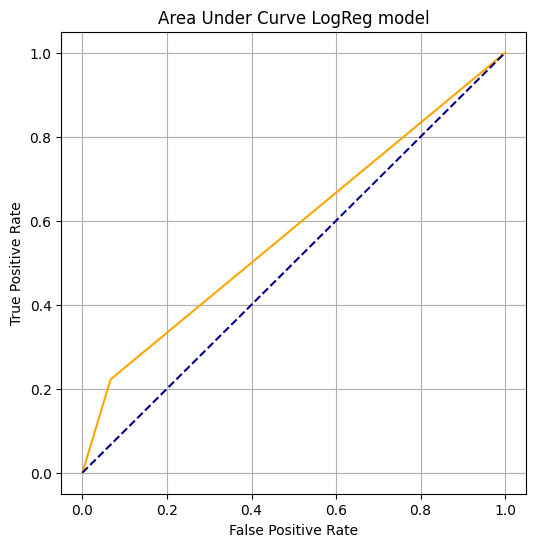

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=100, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [21]:
# XBclassifier 
model = XGBClassifier(eta = 0.01, max_depth = 3, randomstate=42, tree_method = 'hist', max_bin = 100)
# Metrics
train_and_run_dt(X_processed, y, model)

We have managed to reduce model overfitting and improve the precision value. Unfortunately recall is still low, and this is problematic for healthcare models such as predicting MCI. This is because for 14 people who went onto develop MCI, our model did not predict they would develop a MCI. This is risky. 

One reason for this is because we do not have enough data. A solution is to create synthetic datapoints to increase the amount of data we have to train.

In [22]:
# Get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=0)

# Standardize the training and test data
X_train_std, X_test_std = standardise_data(X_train, X_test)

## Make Synthetic data

### Function to create synthetic data

This function generates synthetic data for feature (X) and label (y) data in a binary classification problem.  We pass the feature and label data when we call the number of functions, and (optionally) the number of synthetic data points that we want to create for each class.

We first count the number in each class in the data passed into the function.  The SMOTE implementation in the imbalanced-learn library requires us to specify the TOTAL number of data points we will end up with for each class.  This is the total number we already have for each class + the number of synthetic data points we want to create.  In this example, we're only going to use the synthetic data points as we're using them to replace the existing data, rather than augment, but we still have to go through the same process.

We then tell SMOTE to generate some synthetic data points for each class from the original data points using the `fit_resample()` method.

Once the new synthetic data points have been generated, we have two NumPy arrays - one for each class - which contain all the real data points for that class followed by all the synthetic points for that class.

## Balancing the dataset

If a dataset is 'Imbalanced' this means the number of participants per class is not equally distributed. This can decrease the sensitivity of the model towards minority classes. 

We can check our target variable class balance by looking at the number of participants who remained healthy (0) and those who developed a Mild Cognitive Impairment (1). From this we can see there is an imbalance (larger number of participants who remain unimpaired). This is to be expected, as after 3-5 years we wouldn't expect most of the dataset to become unwell. 

In [23]:
def add_data(X, y, number_of_samples=[1000,1000]):
    """
    Synthetic data generation for two classes.
        
    Inputs
    ------
    original_data: X, y numpy arrays (y should have label 0 and 1)
    number_of_samples: number of samples to generate (list for y=0, y=1)
    (Note - number_of_samples has default of 1000 samples for each class
    if no numbers are specified at the point of calling the function)
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
    
    # Count instances in each class
    count_label_0 = np.sum(y==0)
    count_label_1 = np.sum(y==1)
    
    # SMOTE requires final class counts; add current counts to required counts
    # (which are passed into the function) + 275 more 
    n_class_0 = number_of_samples[0] + count_label_0 
    n_class_1 = number_of_samples[1] + count_label_1 + 275

    # Use SMOTE to sample data points.  The number of points that we pass over
    # to SMOTE is calculated above (the number of synthetic data samples we
    # want, which we passed into the function + the counts from the original
    # data).  This tells SMOTE how many TOTAL data points are needed (original
    # + synthetic) for each class.  It then uses the original data to generate
    # new synthetic data points.
    X_synthetic, y_synthetic = SMOTE(
    sampling_strategy = {0:n_class_0, 1:n_class_1}).fit_resample(X, y)
                                                                  
    return X_synthetic, y_synthetic

In [24]:
# Get counts of classes from y_train
unique, original_frequency = np.unique(y, return_counts = True)
required_smote_count = list(original_frequency * 3)

print(required_smote_count)

[555, 225]


In [25]:
# Call the function we wrote above to generate and extract the synthetic data
X_synthetic, y_synthetic = add_data(
        X_processed, y, number_of_samples=required_smote_count)

y_synthetic.value_counts()

Impaired
0    740
1    575
Name: count, dtype: int64

In [26]:
# Standardise real and synthetic data (standardise based on data in the real 
# training data)
X_train_std, X_synth_std = standardise_data(X_train, X_synthetic)

# Get ALL real X data (combine standardised training + test data)
# We do this because we need to check for duplicates / very close
# values in ALL of the real data we've got
X_real_std = np.concatenate([X_train_std, X_test_std], axis=0)
  
# Use SciKitLearn neighbors.NearestNeighbors to find nearest neighbour
# to each data point. First, we fit to the real standardised data 
# (all of it, train + test set).  Then we can give it the synthetic data
# and ask it to give us the cartesian distance and ID of its nearest
# real world data point neighbour for each synthetic data point.
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors(X_synth_std)

# Store the distances and data point ids (indices) in the synthetic DataFrame
# as two new columns.  This means, for each synthetic "passenger", we'll be
# able to see the closest real "passenger", and how close it is.
# Flatten just reduces something in more than 1 dimension down to
# 1 dimension (eg a list of lists becomes a single list)
X_synthetic['distance_to_closest_real'] = list(dists.flatten())
X_synthetic['closest_X_real_row_index'] = list(idxs.flatten())

In [27]:
# Create new dataframe
synth = pd.DataFrame(X_synthetic)

# Add y values to new dataframe
y = list(y_synthetic)
synth['Impaired'] = y

synth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Apoe4_0                   1315 non-null   int32  
 1   Apoe4_1                   1315 non-null   int32  
 2   Apoe4_2                   1315 non-null   int32  
 3   Gender_1                  1315 non-null   int32  
 4   Gender_2                  1315 non-null   int32  
 5   Eth_1                     1315 non-null   int32  
 6   Eth_2                     1315 non-null   int32  
 7   Race_2                    1315 non-null   int32  
 8   Race_4                    1315 non-null   int32  
 9   Race_5                    1315 non-null   int32  
 10  Race_6                    1315 non-null   int32  
 11  Hand_1                    1315 non-null   int32  
 12  Hand_2                    1315 non-null   int32  
 13  Marry_1                   1315 non-null   int32  
 14  Marry_2 

#### Remove identical points

Let's now get rid of any synthetic data points that are "identical" (or effectively identical) to real data points.  You may find you don't have, depending on how SMOTE generated the points (remember, it's random).

In [28]:
# Get points ("passengers") that are identical to real ones (use distance of 
# <0.001 as effectively identical)
identical = synth['distance_to_closest_real'] < 0.001

print (f"Proportion of data points identical to real data points =",
       f"{identical.mean():0.3f}")

# Remove synthetic data points considered "identical" (as per our definition
# above).  We do this by setting up a mask that says we only want to see data 
# points where the "identical" criterion we specified above is false (ie they're
# not identical).  Then we apply that mask and overwrite our existing synthetic 
# data DataFrame so we've now only got data points that are NOT identical to 
# real world data points.
mask = identical == False
synth_df = synth[mask]

Proportion of data points identical to real data points = 0.000


#### Remove closest points to original data

Now we've removed points that are identical, we're also going to remove the 10% of points that are closest to the original data.

We'll sort our synthetic data points so that those with the highest distances from the nearest real data point (ie those that we want to keep) are at the top.  Then we can just keep the first 90% of data points (thereby removing the 10% that are the closest).  Depending on your data, you might want to play around with this in real world applications.

In [29]:
# Proportion of points to remove
proportion_to_remove = 0.1

# Sort by distance, with highest distances (those we want to keep) at 
# the top
synth_by_distance = synth.sort_values(
    'distance_to_closest_real', ascending=False)

# Limit data.  Calculate the number of entries to keep as being the
# total number of synthetic data points we've now got (after having
# removed ones identical to real world data points) multiplied by
# the proportion we want to keep (the inverse of the proportion to remove).
# As we've sorted in descending order by distance, we can then just
# use .head to identify how much of the top of list we want to keep
# (90% in this case, where we're removing the 10% that are closest - at
# the bottom)
number_to_keep = int(len(synth_by_distance) * (1 - proportion_to_remove))
synth_by_distance = synth_by_distance.head(number_to_keep)

# Shuffle and store back in synth_df (frac=1 gives us a sample size of 100%
# (ie - all of the ones we said above we wanted to keep))
synth = synth_by_distance.sample(frac=1)

In [30]:
synth.drop(columns = ['distance_to_closest_real', 'closest_X_real_row_index'])

,Apoe4_0,Apoe4_1,Apoe4_2,Gender_1,Gender_2,Eth_1,Eth_2,Race_2,Race_4,Race_5,...,FAQ,Age,Weight,Height,Temp,Systolic,Diastolic,Pulse,Resp,Impaired
1291,0,0,0,0,1,0,1,0,0,1,...,0.000000,69.244184,77.488369,169.244184,97.748061,119.496123,66.015509,69.984491,16.000000,1
818,0,0,0,0,0,0,1,0,0,1,...,1.936395,71.222619,70.095408,172.872789,98.000000,132.000000,79.936395,71.872789,17.936395,1
174,1,0,0,1,0,0,1,0,0,1,...,0.000000,77.000000,87.000000,160.000000,97.000000,126.000000,60.000000,52.000000,12.000000,0
617,0,0,0,0,1,0,1,0,0,1,...,0.000000,69.484041,72.122343,178.819151,97.696808,159.393616,83.058506,67.606384,17.393616,0
761,1,0,0,0,0,0,1,0,0,1,...,0.000000,74.290955,66.709045,173.709045,97.177261,159.177261,80.418090,62.063568,16.354523,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1,0,0,0,1,0,1,0,0,1,...,0.000000,71.716304,66.000000,157.897671,99.000000,136.897671,82.204658,80.976708,17.386025,0
456,0,1,0,0,1,0,1,0,0,1,...,0.000000,71.079341,70.444613,178.396705,98.000000,136.714068,84.238023,79.603295,16.000000,0
741,1,0,0,0,0,0,1,0,0,1,...,0.000000,76.019800,75.647274,180.764850,97.372525,157.490100,92.647274,70.137375,19.254950,0
870,1,0,0,1,0,0,1,0,0,1,...,0.000000,84.384699,49.974256,146.871646,97.000000,141.256345,85.666788,60.179478,22.358956,1


In [31]:
synth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1183 entries, 1291 to 1188
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Apoe4_0                   1183 non-null   int32  
 1   Apoe4_1                   1183 non-null   int32  
 2   Apoe4_2                   1183 non-null   int32  
 3   Gender_1                  1183 non-null   int32  
 4   Gender_2                  1183 non-null   int32  
 5   Eth_1                     1183 non-null   int32  
 6   Eth_2                     1183 non-null   int32  
 7   Race_2                    1183 non-null   int32  
 8   Race_4                    1183 non-null   int32  
 9   Race_5                    1183 non-null   int32  
 10  Race_6                    1183 non-null   int32  
 11  Hand_1                    1183 non-null   int32  
 12  Hand_2                    1183 non-null   int32  
 13  Marry_1                   1183 non-null   int32  
 14  Marry_2   

In [32]:
synth['Impaired'].value_counts()

Impaired
0    655
1    528
Name: count, dtype: int64

In [33]:
# Create Target Variable y (whether participant develops impairment or not)
y = synth['Impaired'].astype(int)

# Create dataset of predictor variables X
X = synth.drop(columns=["Impaired"])

Accuracy of predicting training data = 0.847
Accuracy of predicting test data = 0.792
Precision on test data = 0.814
Recall on test data = 0.649
Specificity on test data = 0.781


c:\Users\thoma\anaconda3\envs\ML\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


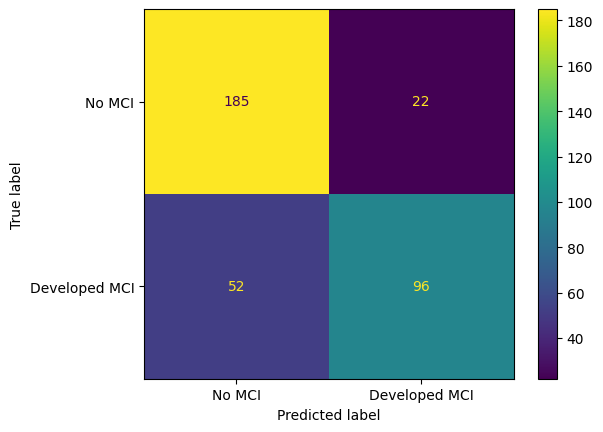

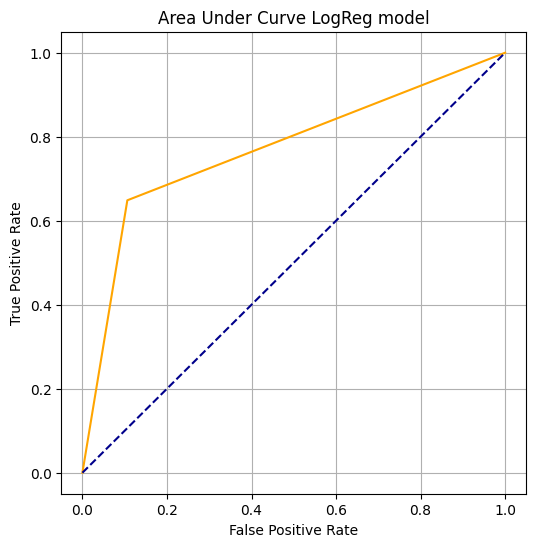

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=100, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [34]:
train_and_run_dt(X, y, model)

We can see that after creating synthetic data and adding this to our model we managed to improve the performance metrics. 

It is a good example showing the limitations of models that are trained on too little data. 